In [5]:
%pip install tensorflow-macos
%pip install tensorflow-metal

ERROR: Could not find a version that satisfies the requirement tensorflow-macos (from versions: none)
ERROR: No matching distribution found for tensorflow-macos
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tensorflow-metal (from versions: none)
ERROR: No matching distribution found for tensorflow-metal
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Read libraries

# Data wrangling
import pandas as pd
import numpy as np
import re
from shapely import wkt
import fiona

# Visualization 
import missingno as msno
import matplotlib
import mapclassify
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd

# Geostatistics
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import libpysal as ps
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.lib import weights
from pysal.model import spreg
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.compat import lzip
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from pysal.lib import weights
from splot.libpysal import plot_spatial_weights
from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error

# Machine learning 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_regression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.ensemble import RandomForestRegressor

# Look at this libraries later
#from keras.models import Sequential
#from keras.layers import Dense, Dropout
#from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

/Users/albertcortbanke/miniconda3/envs/msngdata/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/Users/albertcortbanke/miniconda3/envs/msngdata/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/Users/albe

In [7]:
# Read the GeoParquet file without one-hot sampling
gdf_no_oh = gpd.read_parquet('gdf_no_ohe.parquet')

In [8]:
gdf_no_oh

,year,countries,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,...,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,country_code,geometry,globalNorth,ef_score,hf_score,pf_expression_bti,pf_rol_civil
0,2020.0,Albania,Eastern Europe,10.0,10.000000,0.0,7.500000,10.000000,0.0,10.000000,...,7.175250,6.698118,7.112958,ALB,"POLYGON ((20.07142 42.56091, 20.10208 42.53347...",1.0,0,0,0,0
1,2020.0,Algeria,Middle East & North Africa,10.0,9.687083,25.0,5.000000,10.000000,0.0,10.000000,...,7.029528,5.686753,5.778953,DZA,"POLYGON ((8.62203 36.94137, 8.63222 36.88194, ...",0.0,0,0,0,0
2,2020.0,Angola,Sub-Saharan Africa,10.0,9.582498,25.0,7.500000,9.736578,5.0,9.971733,...,6.782923,5.696942,6.227545,AGO,"MULTIPOLYGON (((23.98621 -10.87046, 23.98805 -...",0.0,0,0,0,0
3,2020.0,Argentina,Latin America & the Caribbean,5.0,10.000000,0.0,7.500000,9.925379,2.0,10.000000,...,6.508295,6.225232,5.490538,ARG,"MULTIPOLYGON (((-68.64312 -54.88861, -68.63723...",0.0,0,0,0,0
4,2020.0,Armenia,Caucasus & Central Asia,10.0,10.000000,0.0,7.500000,10.000000,0.0,10.000000,...,7.040738,7.124727,7.756333,ARM,"POLYGON ((46.54038 38.87559, 46.51639 38.87804...",1.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2000.0,Venezuela,Latin America & the Caribbean,10.0,10.000000,0.0,8.231718,10.000000,0.0,10.000000,...,0.315142,4.692328,5.531397,VEN,"MULTIPOLYGON (((-61.18507 8.49674, -61.19417 8...",0.0,0,0,0,1
3482,2000.0,Vietnam,South Asia,10.0,10.000000,0.0,7.964260,10.000000,0.0,10.000000,...,0.000000,3.861879,4.416768,VNM,"MULTIPOLYGON (((104.08288 10.36486, 104.08663 ...",0.0,0,0,0,1
3483,2000.0,Yemen,Middle East & North Africa,5.0,10.000000,0.0,7.044853,8.170079,19.0,7.932996,...,6.988352,5.658095,6.684552,YEM,"MULTIPOLYGON (((52.23416 12.20111, 52.27888 12...",0.0,1,1,0,1
3484,2000.0,Zambia,Sub-Saharan Africa,10.0,10.000000,0.0,7.552838,10.000000,0.0,9.827262,...,8.520369,8.020982,6.799421,ZMB,"POLYGON ((32.94040 -9.40508, 32.93944 -9.41583...",0.0,0,0,0,1


## Feature scaling

Feature scaling is a method used to standardize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.

Note: Before doing feature scaling, make sure to split your data into train and test sets, to avoid data leakage. Data leakage can happen when information from outside your training dataset is used to create the model. This can cause the model to overestimate its accuracy.

First, let's do a **Train-Test Split** with respect to the temporal data nature:

In [9]:
# Sort the data by year
gdf_no_oh = gdf_no_oh.sort_values('year')

# Create the X and y variables
X = gdf_no_oh.drop(['ef_score', 'hf_score', 'pf_expression_bti', 'pf_rol_civil'], axis=1)  # Features
y = gdf_no_oh[['ef_score', 'hf_score', 'pf_expression_bti', 'pf_rol_civil']]  # Targets

# Calculate the index at which to split the data
split_index = int(len(X) * 0.7)

# Perform a chronological train-test split
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [10]:
X_test

,year,countries,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,...,ef_regulation_business_burden,ef_regulation_business_start,ef_regulation_business_impartial,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,country_code,geometry,globalNorth
1151,2014.0,Uganda,Sub-Saharan Africa,10.0,0.000000,864.0,5.0,10.000000,0.0,10.000000,...,3.555556,8.718526,5.2150,8.308705,7.657251,6.330298,8.137080,UGA,"POLYGON ((33.92110 -1.00194, 33.92027 -1.00111...",0.0
1150,2014.0,Turkey,Middle East & North Africa,5.0,10.000000,0.0,5.0,9.174996,38.0,9.056461,...,6.666667,9.549438,3.6500,9.233155,7.466692,6.780473,6.557095,TUR,"MULTIPOLYGON (((25.82444 40.10026, 25.73167 40...",1.0
1149,2014.0,Tunisia,Middle East & North Africa,10.0,10.000000,0.0,5.0,3.483083,43.0,4.795772,...,5.111111,9.606851,5.4100,9.398287,8.385857,6.950506,6.885396,TUN,"MULTIPOLYGON (((10.99361 33.75000, 10.93778 33...",0.0
1148,2014.0,Trinidad and Tobago,Latin America & the Caribbean,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,6.666667,9.624457,6.0350,6.792369,7.646041,6.779593,7.405782,TTO,"MULTIPOLYGON (((-60.92306 10.79722, -60.94445 ...",0.0
1147,2014.0,Togo,Sub-Saharan Africa,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,1.555556,8.748823,4.0625,8.201228,6.973482,5.908318,5.359383,TGO,"POLYGON ((0.91797 10.99640, 0.89056 10.91111, ...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,2020.0,Netherlands,Western Europe,10.0,10.000000,0.0,10.0,9.613328,4.0,9.585069,...,6.000000,9.845924,8.7550,8.286935,8.666090,7.869562,7.777744,NLD,"MULTIPOLYGON (((4.23890 51.35043, 4.22166 51.3...",1.0
107,2020.0,Nepal,South Asia,10.0,10.000000,0.0,7.5,9.589745,7.0,9.339644,...,6.888889,9.067438,6.1450,8.979394,5.774084,6.733793,7.339317,NPL,"POLYGON ((88.14279 27.86605, 88.15248 27.86416...",0.0
106,2020.0,Namibia,Sub-Saharan Africa,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,4.222222,8.177618,8.9525,8.306145,6.614783,6.846120,7.629787,NAM,"POLYGON ((23.47611 -17.62584, 23.82083 -17.560...",0.0
104,2020.0,Mozambique,Sub-Saharan Africa,10.0,0.678979,924.0,5.0,0.000000,333.0,6.770798,...,3.777778,8.332792,3.7375,8.984100,7.758135,5.982076,6.229162,MOZ,"POLYGON ((32.89043 -26.84714, 32.76778 -26.851...",0.0


In [11]:
# Select only numeric features, excluding 'year'
X_train_numeric = X_train.select_dtypes(include=np.number).drop('year', axis=1)
X_test_numeric = X_test.select_dtypes(include=np.number).drop('year', axis=1)

# Initialize a new scaling object for normalizing input variables
scaler = StandardScaler()

# Fit the scaler object to the training data
scaler.fit(X_train_numeric)

# Apply the scaler object to the training and test sets
X_train_scaled = scaler.transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Replace the original numeric columns with the scaled ones
X_train[X_train_numeric.columns] = X_train_scaled
X_test[X_test_numeric.columns] = X_test_scaled

In [12]:
X_train_numeric.columns

Index(['pf_ss_disappearances_disap', 'pf_ss_disappearances_violent',
       'pf_ss_disappearances_violent_data', 'pf_ss_disappearances_organized',
       'pf_ss_disappearances_fatalities',
       'pf_ss_disappearances_fatalities_data', 'pf_ss_disappearances_injuries',
       'pf_ss_disappearances_injuries_data', 'pf_ss_disappearances', 'pf_ss',
       'pf_expression_direct_killed', 'pf_expression_direct_killed_data',
       'pf_expression_direct_jailed', 'pf_expression_direct_jailed_data',
       'pf_expression_direct', 'pf_expression_cld', 'pf_identity_divorce',
       'pf_identity_fgm', 'ef_government_tax_income_data',
       'ef_government_tax_payroll_data', 'ef_government_soa', 'ef_government',
       'ef_legal_protection', 'ef_legal_military', 'ef_legal_integrity',
       'ef_legal_enforcement', 'ef_legal_regulatory', 'ef_legal_police',
       'ef_gender', 'ef_money_sd', 'ef_money_sd_data', 'ef_money_inflation',
       'ef_money_inflation_data', 'ef_money_currency', 'ef_money',
  

In [13]:
y_train.columns

Index(['ef_score', 'hf_score', 'pf_expression_bti', 'pf_rol_civil'], dtype='object')

Feature selection: Recursive Feature Elimination

** Note; same 10 for all, not good

In [14]:
# Initialize a logistic regression model
model = LogisticRegression(solver='liblinear')  # liblinear is good for small datasets and binary classification

# Dictionary to store selected features and their coefficients for each target
selected_features_dict = {}

# Perform RFE for each target
for target in y_train.columns:
    # Initialize RFE
    rfe = RFE(estimator=model, n_features_to_select=10)  # Adjust the number of features to select as necessary

    # Fit RFE to the scaled numeric data
    rfe.fit(X_train_numeric, y_train[target])

    # Get the features selected by RFE
    selected_features = X_train_numeric.columns[rfe.support_]

    # Fit the model on all selected features at once and get the coefficients
    model.fit(X_train_numeric[selected_features], y_train[target])
    coefficients = model.coef_[0]

    # Create a mapping from features to coefficients
    feature_stats = dict(zip(selected_features, coefficients))

    # Append the selected features and their coefficients to the dictionary
    selected_features_dict[target] = feature_stats

# Print the names and coefficients of the final selected features for each target
for target, features in selected_features_dict.items():
    print(f"Target: {target}")
    for feature, coefficient in features.items():
        print(f"Feature: {feature}, Coefficient: {coefficient}")
    print()


Target: ef_score
Feature: pf_expression_cld, Coefficient: -0.2000866543033256
Feature: ef_government, Coefficient: -0.36212621018466373
Feature: ef_legal_military, Coefficient: -0.17082429290073145
Feature: ef_gender, Coefficient: 0.4034623334547869
Feature: ef_money_currency, Coefficient: 0.17077981357193459
Feature: ef_trade_regulatory_nontariff, Coefficient: 0.31416819417124425
Feature: ef_regulation_labor_firing, Coefficient: -0.23400276118761468
Feature: ef_regulation_business_burden, Coefficient: 0.2531733257037225
Feature: ef_regulation_business_impartial, Coefficient: -0.32641562192292917
Feature: globalNorth, Coefficient: -0.522104705121289

Target: hf_score
Feature: pf_expression_cld, Coefficient: -0.2000866543033256
Feature: ef_government, Coefficient: -0.36212621018466373
Feature: ef_legal_military, Coefficient: -0.17082429290073145
Feature: ef_gender, Coefficient: 0.4034623334547869
Feature: ef_money_currency, Coefficient: 0.17077981357193459
Feature: ef_trade_regulatory_n

Feature selection: Mutual Information

In [15]:
# Set the random seed
np.random.seed(42)

# List to store mutual information and coefficients for each feature
mutual_info_list = []
coefficient_list = []

# Calculate mutual information and coefficients for each target
for target in y_train.columns:
    # Calculate mutual information
    mutual_info = mutual_info_regression(X_train_numeric, y_train[target])
    mutual_info_list.append(mutual_info)

    # Fit linear regression to get the coefficients
    model = LogisticRegression()
    model.fit(X_train_numeric, y_train[target])
    coefficients = model.coef_
    coefficient_list.append(coefficients)

# Calculate the average mutual information for each feature
average_mutual_info = np.mean(mutual_info_list, axis=0)

# Reshape the coefficient list to be 1-dimensional
coefficient_array = np.array(coefficient_list)
average_coefficients = np.mean(coefficient_array, axis=0).reshape(-1)

# Create a DataFrame with the mutual information, coefficients, and feature names
mutual_info_df = pd.DataFrame({'Feature': X_train_numeric.columns, 'Mutual Information': average_mutual_info, 'Coefficient': average_coefficients})

# Sort the DataFrame by mutual information in descending order
mutual_info_df = mutual_info_df.sort_values('Mutual Information', ascending=False)

# Select the top 10 features
selected_features_mi = mutual_info_df.head(10)

# Add the new features obtained from mutual information to the dictionary
for target in y_train.columns:
    for index, row in selected_features_mi.iterrows():
        if row['Feature'] not in selected_features_dict[target]:
            selected_features_dict[target][row['Feature']] = row['Coefficient']

# Print the names and coefficients of the final selected features for each target
for target, features in selected_features_dict.items():
    print(f"Target: {target}")
    for feature, coefficient in features.items():
        print(f"Feature: {feature}, Coefficient: {coefficient}")
    print()

Target: ef_score
Feature: pf_expression_cld, Coefficient: -0.2000866543033256
Feature: ef_government, Coefficient: -0.36212621018466373
Feature: ef_legal_military, Coefficient: -0.17082429290073145
Feature: ef_gender, Coefficient: 0.4034623334547869
Feature: ef_money_currency, Coefficient: 0.17077981357193459
Feature: ef_trade_regulatory_nontariff, Coefficient: 0.31416819417124425
Feature: ef_regulation_labor_firing, Coefficient: -0.23400276118761468
Feature: ef_regulation_business_burden, Coefficient: 0.2531733257037225
Feature: ef_regulation_business_impartial, Coefficient: -0.32641562192292917
Feature: globalNorth, Coefficient: -0.522104705121289
Feature: ef_government_soa, Coefficient: -0.09204104712905205
Feature: ef_legal_enforcement, Coefficient: 0.015963935556412272
Feature: ef_regulation_labor_dismissal, Coefficient: 0.055462253712570186
Feature: ef_legal_regulatory, Coefficient: -0.03313281136763819
Feature: ef_legal_integrity, Coefficient: 0.016535952765762293
Feature: ef_mo

Remember, mutual information is a filter method that measures the statistical dependency between two variables, but it doesn't take into account the potential relationships between different features, while RFE is a wrapper method that takes into account the potential relationships between different features by using a specific model to evaluate the importance of each feature. Therefore, these methods can give different results, and using them together can give a more comprehensive view of feature importance.

Feature selection: Backward feature selection

In [16]:
import statsmodels.api as sm

# Convert the scaled arrays back to DataFrames because statsmodels.api doesn't work with arrays
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_numeric.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_numeric.columns)

# As we will be using statsmodels, we need to add a constant (intercept) to our model.
X_train_scaled_df = sm.add_constant(X_train_scaled_df)

# We will use all the target variables one by one and find out the significant features for each.
for target in y_train.columns:
    y = y_train[target].reset_index(drop=True)  # Reset the index here

    # Define the model
    model = sm.Logit(y, X_train_scaled_df)

    # Fit the model
    result = model.fit(maxiter=100, disp=0)

    # Backward Elimination
    cols = list(X_train_scaled_df.columns)
    pmax = 1
    while cols:
        p = []
        X_1 = X_train_scaled_df[cols]
        model = sm.Logit(y, X_1).fit(disp=0)
        p = pd.Series(model.pvalues.values[1:], index = cols[1:])
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax > 0.05):
            cols.remove(feature_with_p_max)
        else:
            break

    # Update the selected_features_dict with the significant features for each target
    for feature in cols:
        if feature not in selected_features_dict[target] and feature != 'const':  # 'const' is not a real feature so we ignore it
            selected_features_dict[target][feature] = 'NA'  # Coefficient is not applicable for significant features

# Print the names and coefficients of the final selected features for each target
for target, features in selected_features_dict.items():
    print(f"Target: {target}")
    for feature, coefficient in features.items():
        print(f"Feature: {feature}, Coefficient: {coefficient}")
    print()

Target: ef_score
Feature: pf_expression_cld, Coefficient: -0.2000866543033256
Feature: ef_government, Coefficient: -0.36212621018466373
Feature: ef_legal_military, Coefficient: -0.17082429290073145
Feature: ef_gender, Coefficient: 0.4034623334547869
Feature: ef_money_currency, Coefficient: 0.17077981357193459
Feature: ef_trade_regulatory_nontariff, Coefficient: 0.31416819417124425
Feature: ef_regulation_labor_firing, Coefficient: -0.23400276118761468
Feature: ef_regulation_business_burden, Coefficient: 0.2531733257037225
Feature: ef_regulation_business_impartial, Coefficient: -0.32641562192292917
Feature: globalNorth, Coefficient: -0.522104705121289
Feature: ef_government_soa, Coefficient: -0.09204104712905205
Feature: ef_legal_enforcement, Coefficient: 0.015963935556412272
Feature: ef_regulation_labor_dismissal, Coefficient: 0.055462253712570186
Feature: ef_legal_regulatory, Coefficient: -0.03313281136763819
Feature: ef_legal_integrity, Coefficient: 0.016535952765762293
Feature: ef_mo

**Time-series validation**: The method is also known as "rolling forecasting origin" or "walk-forward validation" in the context of time series forecasting

## Modelling: Statistical

### Logistic Regression

In [17]:
# Initialize a dictionary to store models
models = {}

for target in selected_features_dict.keys():
    print(f"Training model for {target}")
    
    # Get the best features for the target
    best_features = selected_features_dict[target]
    
    # Subset X_train and X_test to only include the best features
    X_train_best = X_train[best_features]
    X_test_best = X_test[best_features]

    # Fit the model
    clf = LogisticRegression(random_state=0).fit(X_train_best, y_train[target])

    # Store the model
    models[target] = clf

    # Make predictions and evaluate
    y_pred = clf.predict(X_test_best)
    print(classification_report(y_test[target], y_pred))

Training model for ef_score
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1031
           1       0.07      0.27      0.11        15

    accuracy                           0.94      1046
   macro avg       0.53      0.61      0.54      1046
weighted avg       0.98      0.94      0.95      1046

Training model for hf_score
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1031
           1       0.07      0.27      0.11        15

    accuracy                           0.94      1046
   macro avg       0.53      0.61      0.54      1046
weighted avg       0.98      0.94      0.95      1046

Training model for pf_expression_bti
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       781
           1       0.72      0.76      0.74       265

    accuracy                           0.86      1046
   macro avg       0.82      0.83  

### Random Forest & XGBoost with GridSearch optimization

In [21]:

# Initialize dictionaries to store the best models
best_models_rf = {}
best_models_xgb = {}

# Define the grids of hyperparameters to search over
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 2, 4, 6],
    'min_samples_split': [2, 5, 10]
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.2]
}

for target in selected_features_dict.keys():
    print(f"Performing grid search for models for {target}")

    # Get the best features for the target
    best_features = list(selected_features_dict[target].keys())

    # Subset X_train and X_test to only include the best features
    X_train_best = X_train[best_features]
    X_test_best = X_test[best_features]

    # Perform grid search for the Random Forest model
    print("Performing grid search for Random Forest Model")
    rf_grid = GridSearchCV(RandomForestClassifier(random_state=0), rf_params, cv=5)
    rf_grid.fit(X_train_best, y_train[target])

    # Store the best model
    best_models_rf[target] = rf_grid.best_estimator_
    
    # Random Forest model
    print(f"Classification report for Random Forest model, {target}")
    y_pred_rf = best_models_rf[target].predict(X_test_best)
    print(classification_report(y_test[target], y_pred_rf))

    # Plot feature importance
    importances = best_models_rf[target].feature_importances_
    fig = go.Figure(go.Bar(
        x=importances, 
        y=best_features, 
        orientation='h',
        marker=dict(
            color='rgba(58, 71, 80, 0.6)',
            line=dict(color='rgba(58, 71, 80, 1.0)', width=3)
        )
    ))
    fig.update_layout(title_text=f'Feature importances for RandomForest for target {target}')
    fig.show()

    # Perform grid search for the XGBoost model
    print("Performing grid search for XGBoost Model")
    xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss"), xgb_params, cv=5)
    xgb_grid.fit(X_train_best, y_train[target])

    # Store the best model
    best_models_xgb[target] = xgb_grid.best_estimator_

    # XGBoost model
    print(f"Classification report for XGBoost model, {target}")
    y_pred_xgb = best_models_xgb[target].predict(X_test_best)
    print(classification_report(y_test[target], y_pred_xgb))
    
    # Plot feature importance
    importances = best_models_xgb[target].feature_importances_
    fig = go.Figure(go.Bar(
        x=importances, 
        y=best_features, 
        orientation='h',
        marker=dict(
            color='rgba(58, 71, 80, 0.6)',
            line=dict(color='rgba(58, 71, 80, 1.0)', width=3)
        )
    ))
    fig.update_layout(title_text=f'Feature importances for RandomForest for target {target}')
    fig.show()

Performing grid search for models for ef_score
Performing grid search for Random Forest Model


In [18]:
# Initialize dictionaries to store the best models
best_models_rf = {}
best_models_xgb = {}

# Define the grids of hyperparameters to search over
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 2, 4, 6],
    'min_samples_split': [2, 5, 10]
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.2]
}

for target in selected_features_dict.keys():
    print(f"Performing grid search for models for {target}")

    # Get the best features for the target
    best_features = list(selected_features_dict[target].keys())

    # Subset X_train and X_test to only include the best features
    X_train_best = X_train[best_features]
    X_test_best = X_test[best_features]

    # Perform grid search for the Random Forest model
    print("Performing grid search for Random Forest Model")
    rf_grid = GridSearchCV(RandomForestClassifier(random_state=0), rf_params, cv=5)
    rf_grid.fit(X_train_best, y_train[target])

    # Store the best model
    best_models_rf[target] = rf_grid.best_estimator_
    
    # Random Forest model
    print(f"Classification report for Random Forest model, {target}")
    y_pred_rf = best_models_rf[target].predict(X_test_best)
    print(classification_report(y_test[target], y_pred_rf))

    # Perform grid search for the XGBoost model
    print("Performing grid search for XGBoost Model")
    xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss"), xgb_params, cv=5)
    xgb_grid.fit(X_train_best, y_train[target])

    # Store the best model
    best_models_xgb[target] = xgb_grid.best_estimator_

    # XGBoost model
    print(f"Classification report for XGBoost model, {target}")
    y_pred_xgb = best_models_xgb[target].predict(X_test_best)
    print(classification_report(y_test[target], y_pred_xgb))

Performing grid search for models for ef_score
Performing grid search for Random Forest Model


KeyboardInterrupt: 

In [19]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the grids of hyperparameters to search over
ada_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1]
}

# Initialize dictionary to store the best models
best_models_ada = {}

for target in selected_features_dict.keys():
    print(f"Performing grid search for models for {target}")

    # Get the best features for the target
    best_features = list(selected_features_dict[target].keys())

    # Subset X_train and X_test to only include the best features
    X_train_best = X_train[best_features]
    X_test_best = X_test[best_features]

    # Perform grid search for the AdaBoost model
    print("Performing grid search for AdaBoost Model")
    ada_grid = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=0), ada_params, cv=5)
    ada_grid.fit(X_train_best, y_train[target])

    # Store the best model
    best_models_ada[target] = ada_grid.best_estimator_

    # AdaBoost model
    print(f"Classification report for AdaBoost model, {target}")
    y_pred_ada = best_models_ada[target].predict(X_test_best)
    print(classification_report(y_test[target], y_pred_ada))

Performing grid search for models for ef_score
Performing grid search for AdaBoost Model
Classification report for AdaBoost model, ef_score
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1031
           1       0.94      1.00      0.97        15

    accuracy                           1.00      1046
   macro avg       0.97      1.00      0.98      1046
weighted avg       1.00      1.00      1.00      1046

Performing grid search for models for hf_score
Performing grid search for AdaBoost Model
Classification report for AdaBoost model, hf_score
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1031
           1       0.94      1.00      0.97        15

    accuracy                           1.00      1046
   macro avg       0.97      1.00      0.98      1046
weighted avg       1.00      1.00      1.00      1046

Performing grid search for models for pf_expression_bti
Performing

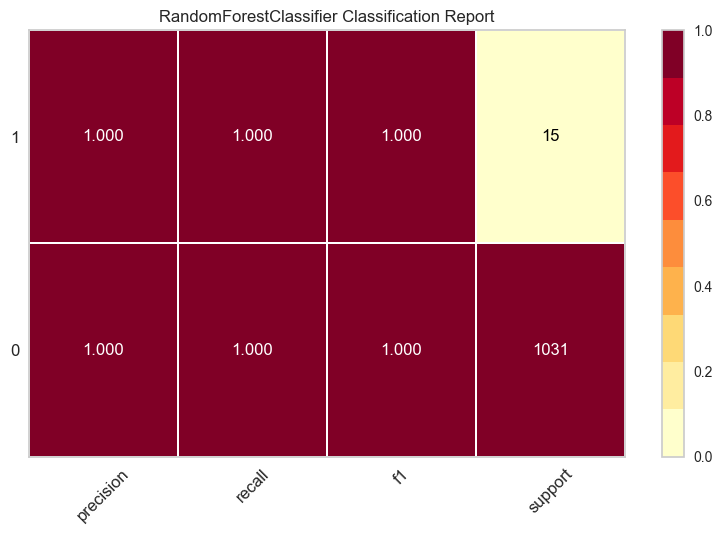

KeyError: 'ef_score'

In [ ]:
from yellowbrick.classifier import ClassificationReport

for target in selected_features_dict.keys():
    best_features = list(selected_features_dict[target].keys())
    X_train_best = X_train[best_features]
    X_test_best = X_test[best_features]

    # Random Forest
    visualizer_rf = ClassificationReport(best_models_rf[target], classes=np.unique(y_train[target]), support=True)
    visualizer_rf.fit(X_train_best, y_train[target])  
    visualizer_rf.score(X_test_best, y_test[target])  
    visualizer_rf.show()       

    # XGBoost
    visualizer_xgb = ClassificationReport(best_models_xgb[target], classes=np.unique(y_train[target]), support=True)
    visualizer_xgb.fit(X_train_best, y_train[target])  
    visualizer_xgb.score(X_test_best, y_test[target])  
    visualizer_xgb.show()       

### AdaBoost and Neural Network

## Modelling: Genetic

## Modelling: Spatial